In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

1. Gerekli Kütüphanelerin İmport Edilmesi

In [2]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
from collections import Counter

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Uyarıları gizlemek için
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi!")
print(f"TensorFlow versiyonu: {tf.__version__}")

2025-09-25 11:26:41.207662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758799601.404397      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758799601.463610      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Kütüphaneler başarıyla yüklendi!
TensorFlow versiyonu: 2.18.0


2. Veri Seti Yükleme ve İnceleme

In [3]:
# Kaggle veri seti yolunu belirtme
DATASET_PATH = '/kaggle/input/intel-image-classification'

# Eğitim ve test klasörleri
train_dir = os.path.join(DATASET_PATH, 'seg_train/seg_train')
test_dir = os.path.join(DATASET_PATH, 'seg_test/seg_test')

# Sınıf isimlerini alma
class_names = os.listdir(train_dir)
print(f"Sınıf sayısı: {len(class_names)}")
print(f"Sınıf isimleri: {class_names}")

# Her sınıftaki görüntü sayısını kontrol etme
for class_name in class_names:
    train_class_path = os.path.join(train_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)
    
    train_count = len(os.listdir(train_class_path))
    test_count = len(os.listdir(test_class_path)) if os.path.exists(test_class_path) else 0
    
    print(f"{class_name}: Eğitim={train_count}, Test={test_count}")

Sınıf sayısı: 6
Sınıf isimleri: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
mountain: Eğitim=2512, Test=525
street: Eğitim=2382, Test=501
buildings: Eğitim=2191, Test=437
sea: Eğitim=2274, Test=510
forest: Eğitim=2271, Test=474
glacier: Eğitim=2404, Test=553


3. Veri Görselleştirme

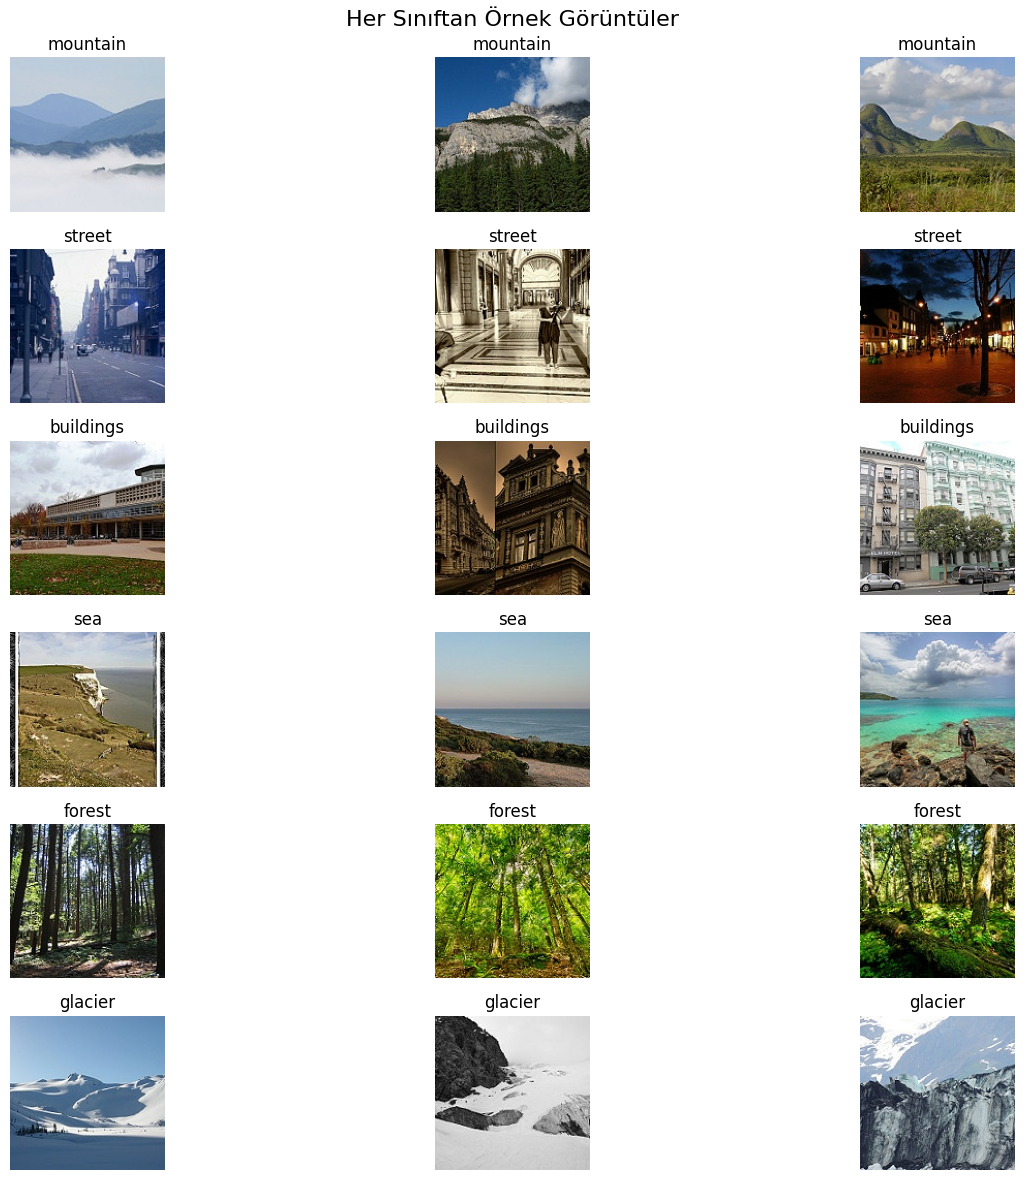

In [4]:
def plot_sample_images(data_dir, class_names, samples_per_class=3):
    """Her sınıftan örnek görüntüleri göster"""
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(15, 12))
    fig.suptitle('Her Sınıftan Örnek Görüntüler', fontsize=16)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Örnek görüntüleri göster
plot_sample_images(train_dir, class_names)

4. Veri Dağılımını Analiz Etme

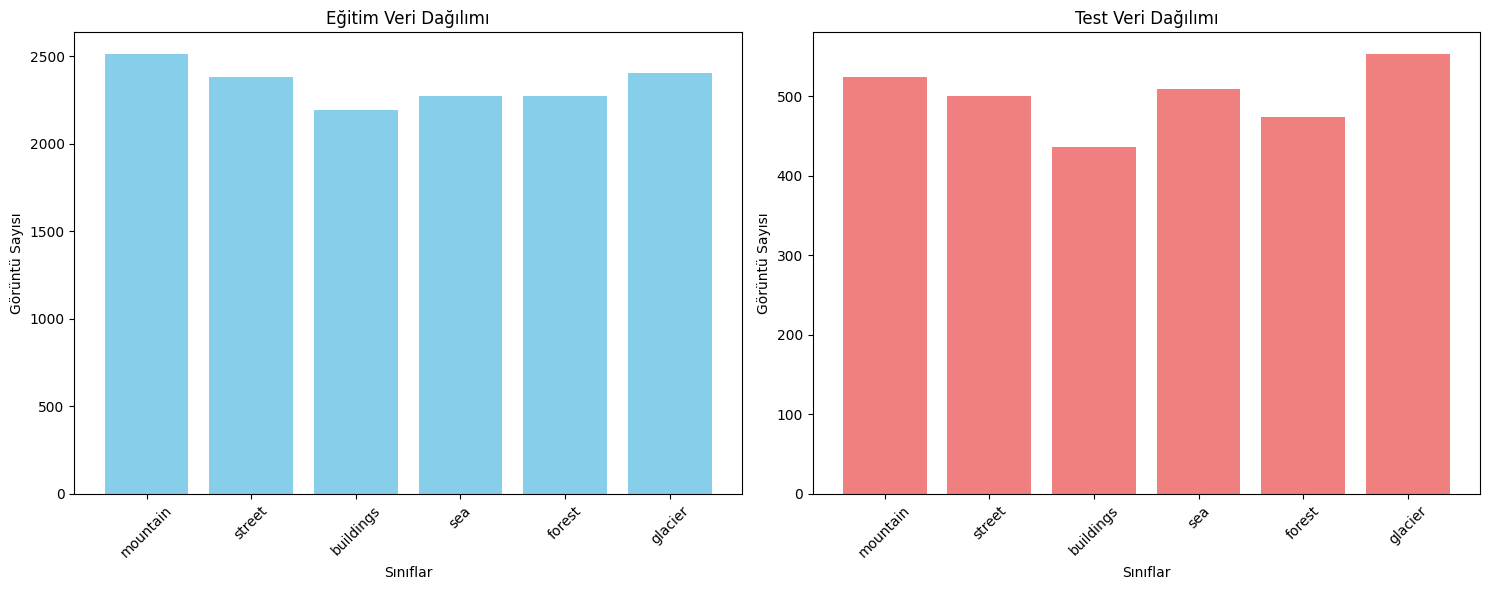

Toplam eğitim görüntü sayısı: 14034
Toplam test görüntü sayısı: 3000
Ortalama eğitim görüntü/sınıf: 2339


In [5]:
# Sınıf dağılımını hesaplama
train_counts = []
test_counts = []

for class_name in class_names:
    train_class_path = os.path.join(train_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)
    
    train_count = len(os.listdir(train_class_path))
    test_count = len(os.listdir(test_class_path)) if os.path.exists(test_class_path) else 0
    
    train_counts.append(train_count)
    test_counts.append(test_count)

# Veri dağılımını görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Eğitim veri dağılımı
ax1.bar(class_names, train_counts, color='skyblue')
ax1.set_title('Eğitim Veri Dağılımı')
ax1.set_xlabel('Sınıflar')
ax1.set_ylabel('Görüntü Sayısı')
ax1.tick_params(axis='x', rotation=45)

# Test veri dağılımı
ax2.bar(class_names, test_counts, color='lightcoral')
ax2.set_title('Test Veri Dağılımı')
ax2.set_xlabel('Sınıflar')
ax2.set_ylabel('Görüntü Sayısı')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# İstatistiksel bilgiler
print(f"Toplam eğitim görüntü sayısı: {sum(train_counts)}")
print(f"Toplam test görüntü sayısı: {sum(test_counts)}")
print(f"Ortalama eğitim görüntü/sınıf: {np.mean(train_counts):.0f}")

5. Görüntü Boyutlarını Analiz Etme

In [6]:
def analyze_image_dimensions(data_dir, class_names, sample_size=100):
    """Görüntü boyutlarını analiz et"""
    widths = []
    heights = []
    
    for class_name in class_names[:2]:  # İlk 2 sınıftan örnekleme
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:sample_size//len(class_names)]
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    widths.append(img.size[0])
                    heights.append(img.size[1])
            except:
                continue
    
    print(f"Ortalama genişlik: {np.mean(widths):.0f} px")
    print(f"Ortalama yükseklik: {np.mean(heights):.0f} px")
    print(f"En yaygın boyut: {Counter(list(zip(widths, heights))).most_common(1)[0]}")
    
    return widths, heights

# Görüntü boyutlarını analiz et
widths, heights = analyze_image_dimensions(train_dir, class_names)

Ortalama genişlik: 150 px
Ortalama yükseklik: 150 px
En yaygın boyut: ((150, 150), 32)


6. Veri Ön İşleme ve Artırma

In [7]:
# Görüntü boyutları
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Eğitim verisi için veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.2  # %20'si doğrulama için ayrılacak
)

# Test verisi için sadece normalleştirme
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim veri jeneratörü
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Doğrulama veri jeneratörü
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test veri jeneratörü
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print(f"Eğitim örnekleri: {train_generator.samples}")
print(f"Doğrulama örnekleri: {validation_generator.samples}")
print(f"Test örnekleri: {test_generator.samples}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Eğitim örnekleri: 11230
Doğrulama örnekleri: 2804
Test örnekleri: 3000


7. Basit CNN Modeli Oluşturma

In [8]:
def create_basic_cnn_model():
    """Basit CNN modeli oluştur"""
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    
    return model

# Modeli oluştur ve özet bilgileri göster
basic_model = create_basic_cnn_model()
basic_model.summary()

I0000 00:00:1758799619.991187      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

8. Transfer Learning Modeli (VGG16)

In [9]:
def create_transfer_learning_model():
    """VGG16 kullanarak transfer learning modeli oluştur"""
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Temel modelin katmanlarını dondur
    base_model.trainable = False
    
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    
    return model

# Transfer learning modelini oluştur
transfer_model = create_transfer_learning_model()
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,126 (56.39 MB)

 Trainable params: 66,438 (259.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

9. Model Eğitimi

In [10]:
# Modeli derle
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback'leri tanımla
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

# Modeli eğit
EPOCHS = 20

history = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("Model eğitimi tamamlandı!")

Epoch 1/20


I0000 00:00:1758799629.138153      81 service.cc:148] XLA service 0x7e158400c7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758799629.139060      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758799629.556473      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/350 ━━━━━━━━━━━━━━━━━━━━ 46:06 8s/step - accuracy: 0.1562 - loss: 2.1737

I0000 00:00:1758799634.773383      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 188s 515ms/step - accuracy: 0.5285 - loss: 1.1644 - val_accuracy: 0.7899 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8125 - loss: 0.5595 - val_accuracy: 0.7841 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.7589 - loss: 0.6601 - val_accuracy: 0.7996 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6562 - loss: 0.7121 - val_accuracy: 0.7967 - val_loss: 0.5400 - learning_rate: 0.0010
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.7824 - loss: 0.5860 - val_accuracy: 0.8107 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.7188 - loss: 0.8500 - val_accuracy: 0.8085 - val_loss: 0.5059 - learning_rate: 0.0010
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 240ms/step - accuracy: 0.7950 - loss: 0

10. Eğitim Sonuçlarını Görselleştirme

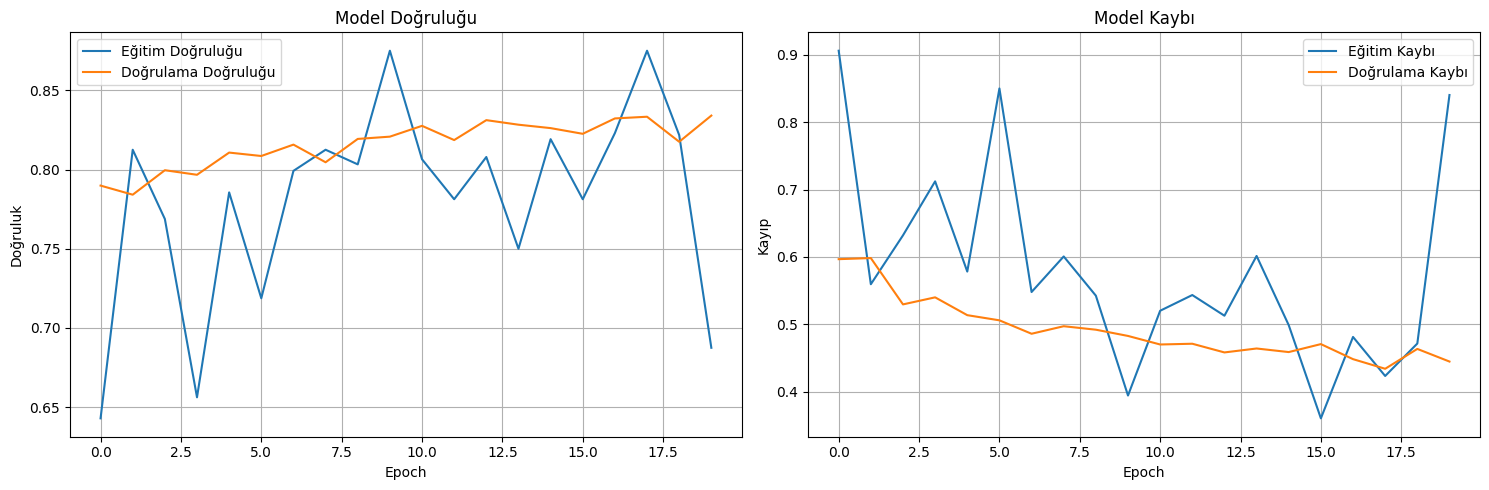

In [11]:
def plot_training_history(history):
    """Eğitim geçmişini görselleştir"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Doğruluk grafiği
    ax1.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    ax1.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    ax1.set_title('Model Doğruluğu')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Doğruluk')
    ax1.legend()
    ax1.grid(True)
    
    # Kayıp grafiği
    ax2.plot(history.history['loss'], label='Eğitim Kaybı')
    ax2.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    ax2.set_title('Model Kaybı')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Kayıp')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Eğitim geçmişini görselleştir
plot_training_history(history)

11. Model Değerlendirme

In [12]:
# Test setinde tahmin yapma
test_loss, test_accuracy = transfer_model.evaluate(test_generator, verbose=0)
print(f"Test Doğruluğu: {test_accuracy:.4f}")
print(f"Test Kaybı: {test_loss:.4f}")

# Detaylı tahminler
test_generator.reset()
predictions = transfer_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketleri alma
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Test Doğruluğu: 0.8523
Test Kaybı: 0.3850
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   buildings       0.14      0.14      0.14       437
      forest       0.16      0.16      0.16       474
     glacier       0.16      0.20      0.18       553
    mountain       0.18      0.14      0.16       525
         sea       0.17      0.16      0.17       510
      street       0.21      0.20      0.21       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



12. Karışıklık Matrisi

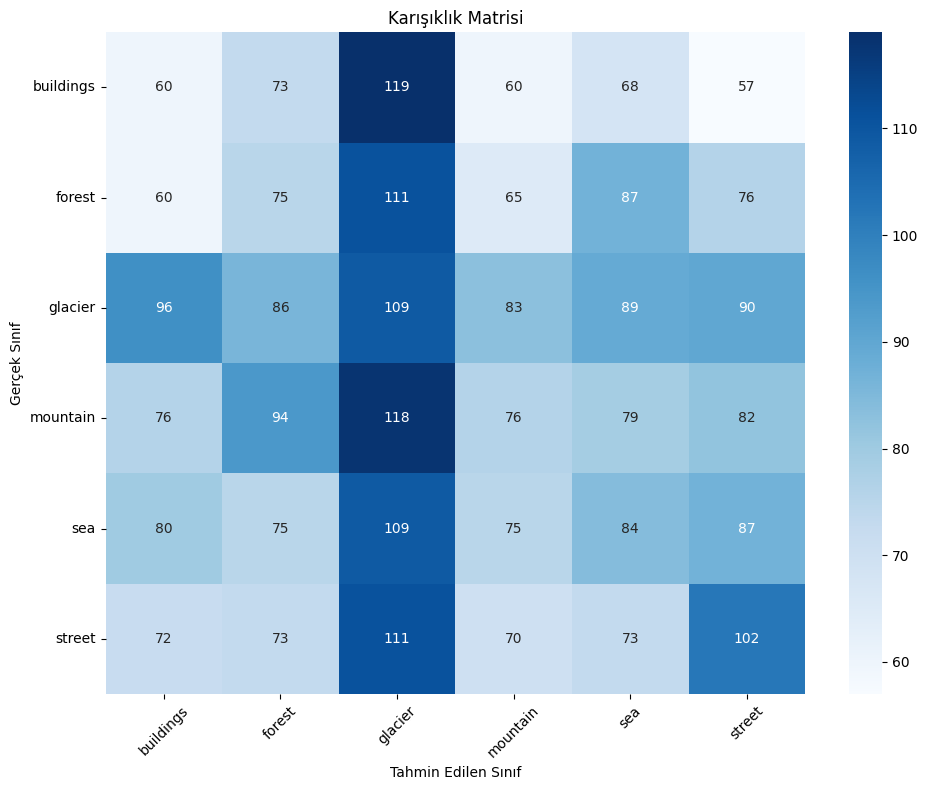

buildings: 0.1373
forest: 0.1582
glacier: 0.1971
mountain: 0.1448
sea: 0.1647
street: 0.2036


In [13]:
# Karışıklık matrisini hesapla
cm = confusion_matrix(true_classes, predicted_classes)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Her sınıf için doğruluk
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(class_labels):
    print(f"{class_name}: {class_accuracy[i]:.4f}")

13. Yanlış Sınıflandırılan Görüntüleri Görselleştirme

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


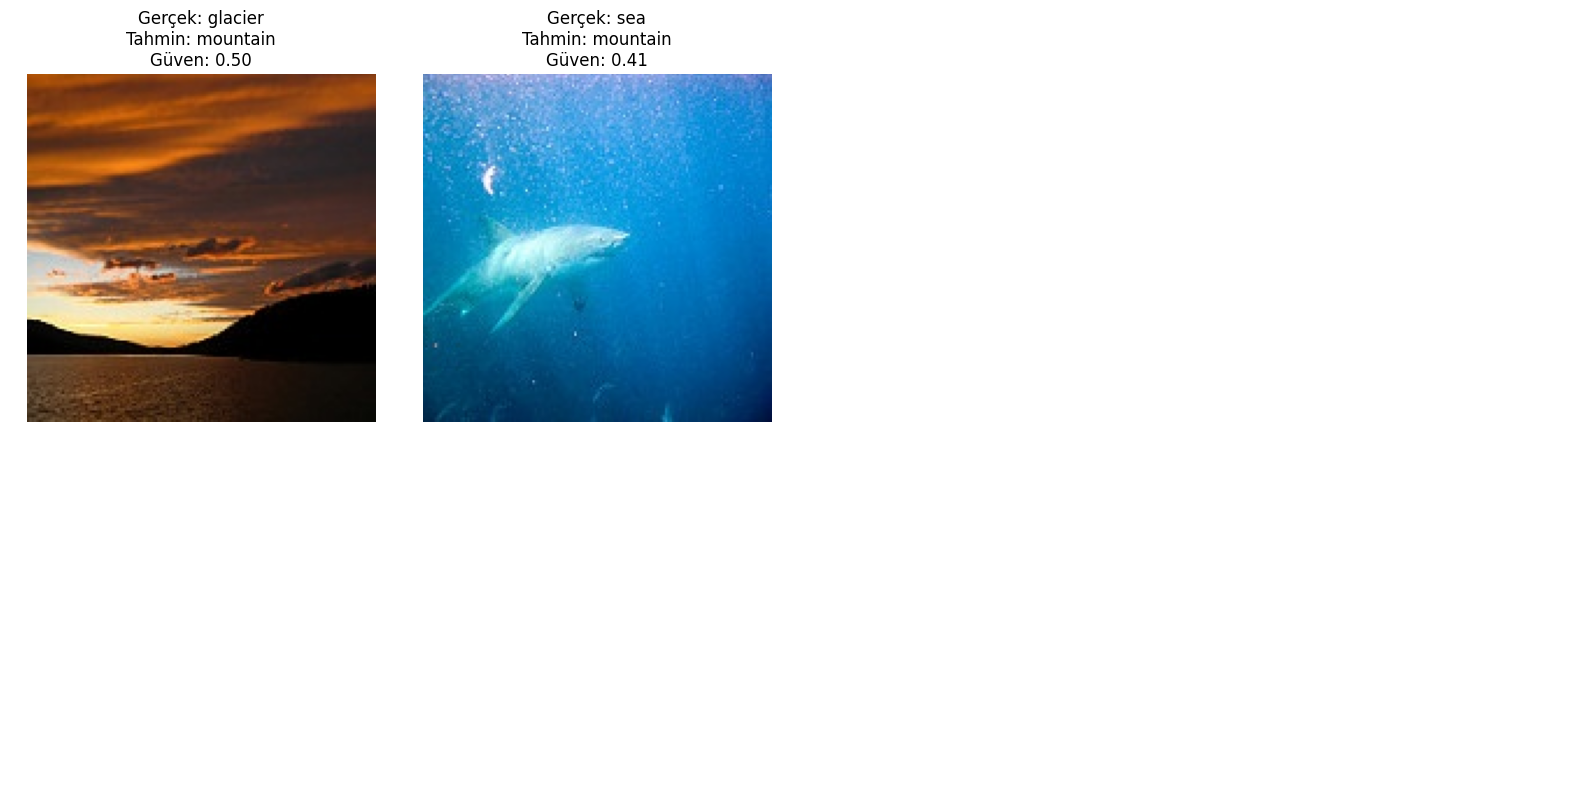

In [14]:
def plot_misclassified_images(generator, model, class_labels, num_images=8):
    """Yanlış sınıflandırılan görüntüleri göster"""
    generator.reset()
    
    # Bir batch tahmin yap
    batch_images, batch_labels = next(generator)
    predictions = model.predict(batch_images)
    
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)
    
    # Yanlış tahminleri bul
    misclassified_indices = np.where(predicted_classes != true_classes)[0]
    
    if len(misclassified_indices) == 0:
        print("Bu batch'te yanlış sınıflandırma bulunamadı.")
        return
    
    # İlk num_images kadar yanlış tahmini göster
    num_to_show = min(num_images, len(misclassified_indices))
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(num_to_show):
        idx = misclassified_indices[i]
        img = batch_images[idx]
        true_class = class_labels[true_classes[idx]]
        pred_class = class_labels[predicted_classes[idx]]
        confidence = np.max(predictions[idx])
        
        axes[i].imshow(img)
        axes[i].set_title(f'Gerçek: {true_class}\nTahmin: {pred_class}\nGüven: {confidence:.2f}')
        axes[i].axis('off')
    
    # Kullanılmayan subplot'ları gizle
    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Yanlış sınıflandırılan görüntüleri göster
plot_misclassified_images(test_generator, transfer_model, class_labels)

14. Modeli Kaydetme

In [15]:
# Modeli kaydet
model_save_path = 'intel_image_classification_model.h5'
transfer_model.save(model_save_path)
print(f"Model {model_save_path} olarak kaydedildi.")

# Model mimarisini JSON olarak kaydet
model_json = transfer_model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("Model mimarisi JSON olarak kaydedildi.")

Model intel_image_classification_model.h5 olarak kaydedildi.
Model mimarisi JSON olarak kaydedildi.


15. Tek Görüntü Tahmini

In [16]:
def predict_single_image(model, image_path, class_labels):
    """Tek bir görüntü için tahmin yap"""
    # Görüntüyü yükle ve ön işle
    img = Image.open(image_path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Tahmin yap
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    
    # Sonuçları göster
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Tahmin: {predicted_class} (Güven: {confidence:.2f})')
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Örnek kullanım (bir test görüntüsü ile)
# test_image_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20068.jpg'
# predicted_class, confidence = predict_single_image(transfer_model, test_image_path, class_labels)

Sonuç ve Öneriler
Bu rehber Intel Image Classification veri seti ile:

1.Veri keşfi ve görselleştirme işlemlerini gerçekleştirdik
2.Transfer Learning kullanarak etkili bir model oluşturduk
3.Model performansını değerlendirdik ve görselleştirdik
4.Yanlış sınıflandırmaları analiz ettik